In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [29]:
class TimeSeriesData():
    
    def __init__(self,num_points,xmin,xmax):
        self.xmin=xmin
        self.xmax=xmax
        self.num_points=num_points
        self.resolution=(xmax-xmin)/num_points
        self.x_data = np.linspace(xmin,xmax,num_points)
        self.y_true = np.sin(self.x_data)
    
    def ret_true(self,x_series):
        return np.sin(x_series)
  
    def next_batch(self,batch_size,steps,return_batch_ts=False):
        # grab a random starting point for each batch
        rand_start = np.random.rand(batch_size,1)
        # convert to be on time series 
        ts_start = rand_start*(self.xmax - self.xmin - (steps*self.resolution))
        # create the Y data for the time series x axis from previous step
        batch_ts = ts_start + np.arange(0.0,steps+1) * self.resolution 
        # create the Y data for the time series x axis from previous step
        y_batch = np.sin(batch_ts)
        #formatting for RNN :
        
        if return_batch_ts:
            return y_batch[:,:-1].reshape(-1,steps,1), y_batch[:,1:].reshape(-1,steps,1),batch_ts          
        else:
            return y_batch[:,:-1].reshape(-1,steps,1),y_batch[:,1:].reshape(-1,steps,1)
                               
        

In [30]:
ts_data=TimeSeriesData(250,0,10)

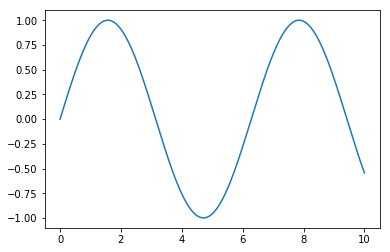

In [31]:
plt.plot(ts_data.x_data,ts_data.y_true)

In [32]:
num_time_steps =30

In [50]:
y1,y2,ts=ts_data.next_batch(1,num_time_steps,True)

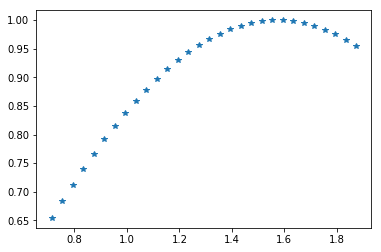

In [51]:
plt.plot(ts.flatten()[1:],y2.flatten(),"*")

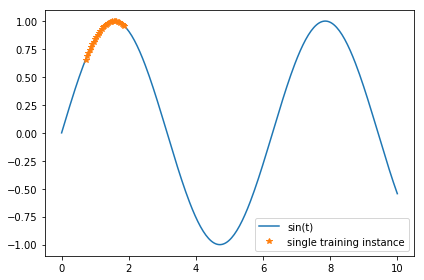

In [52]:
plt.plot(ts_data.x_data,ts_data.y_true,label="sin(t)")
plt.plot(ts.flatten()[1:],y2.flatten(),"*",label="single training instance")
plt.legend()
plt.tight_layout()

In [53]:
tf.reset_default_graph()

In [76]:
train_inst=np.linspace(5,5 +ts_data.resolution*(num_time_steps+1),num_time_steps + 1)

In [77]:
train_inst

array([ 5.        ,  5.04133333,  5.08266667,  5.124     ,  5.16533333,
        5.20666667,  5.248     ,  5.28933333,  5.33066667,  5.372     ,
        5.41333333,  5.45466667,  5.496     ,  5.53733333,  5.57866667,
        5.62      ,  5.66133333,  5.70266667,  5.744     ,  5.78533333,
        5.82666667,  5.868     ,  5.90933333,  5.95066667,  5.992     ,
        6.03333333,  6.07466667,  6.116     ,  6.15733333,  6.19866667,
        6.24      ])

In [56]:
num_inputs =1 

In [58]:
num_neurons=100
num_outputs=1
learning_rate=0.0001
num_train_iterations=2000
batch_size=1

In [59]:
X=tf.placeholder(tf.float32,[None,num_time_steps,num_inputs])
Y=tf.placeholder(tf.float32,[None,num_time_steps,num_outputs])

In [61]:
# Creating the rnn cell layer :
cell = tf.contrib.rnn.OutputProjectionWrapper(
    tf.contrib.rnn.BasicRNNCell(num_units=num_neurons,activation=tf.nn.relu),output_size=num_outputs)

In [62]:
outputs,states=tf.nn.dynamic_rnn(cell,X,dtype=tf.float32)

In [64]:
loss = tf.reduce_mean(tf.square(outputs-Y))

In [65]:
optmizer = tf.train.AdamOptimizer(learning_rate=learning_rate)

In [67]:
train = optmizer.minimize(loss)

In [68]:
init = tf.global_variables_initializer()

In [69]:
saver = tf.train.Saver()

In [71]:
with tf.Session() as sess:
    sess.run(init)
    
    for iteration in range(num_train_iterations):
        
        X_batch,Y_batch = ts_data.next_batch(batch_size,num_time_steps)
        sess.run(train,feed_dict={X:X_batch,Y:Y_batch})
        
        if iteration %100==0:
            mse = loss.eval(feed_dict={X:X_batch,Y:Y_batch})
            print(iteration,"\mse",mse)
        saver.save(sess,"/Users/lovetyagi/Desktop/rnn_time_series")

0 \mse 0.954541
100 \mse 0.201663
200 \mse 0.41523
300 \mse 0.0044539
400 \mse 0.00583472
500 \mse 0.045206
600 \mse 0.0448495
700 \mse 0.0221802
800 \mse 0.0015678
900 \mse 0.0138926
1000 \mse 0.0135838
1100 \mse 0.023403
1200 \mse 0.00100704
1300 \mse 0.00661987
1400 \mse 0.0189135
1500 \mse 0.000299128
1600 \mse 0.0125298
1700 \mse 0.00896138
1800 \mse 0.012533
1900 \mse 0.00384922


In [79]:
with tf.Session() as sess:
    saver.restore(sess,"/Users/lovetyagi/Desktop/rnn_time_series")
    X_new = np.sin(np.array(train_inst[:-1].reshape(-1,num_time_steps,num_inputs)))
    y_pred = sess.run(outputs,feed_dict={X:X_new})

INFO:tensorflow:Restoring parameters from /Users/lovetyagi/Desktop/rnn_time_series


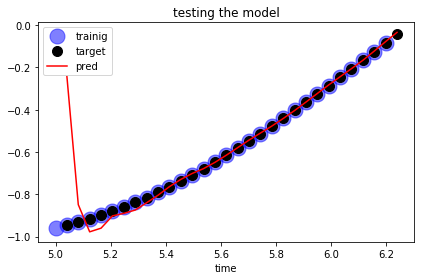

In [80]:
plt.title("testing the model")

# training 

plt.plot(train_inst[:-1],np.sin(train_inst[:-1]),"bo",markersize=15,alpha=.5,label="trainig")

# target to predict 
plt.plot(train_inst[1:],np.sin(train_inst[1:]),"ko",markersize=10,label="target")

plt.plot(train_inst[1:],y_pred[0,:,0],'r',markersize=10,label='pred')
plt.xlabel('time')
plt.legend()
plt.tight_layout()